In [1]:
"""
Python script to scrape Friktion User Data from Bitquery GraphQL API.

"""

import json
import requests
import requests
import traceback
import time

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from os.path import exists

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [96]:
"""
Plotting Formatters
"""

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)

def percents(x, pos):
    'The two args are the value and tick position'
    return "{:.0%}".format(x)


formatter_percents = FuncFormatter(percents)

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

In [97]:
"""
Get current Coingecko prices for analysis
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import json
import ccxt

import datetime

cftx = ccxt.ftx(
    {
        "apiKey":"mvnd3WRG56rAP-6MpxFyZ5sN2WnjEO8UsQB6u-6s",
        "secret":"m_m926E36IMlrhCv6bGkLdSdaVegbm5PggpCrFCM"
    }
)

markets = cftx.load_markets()
binance = ccxt.binance()

# 10 days
time_since = datetime.datetime.timestamp(datetime.datetime.now())*1000-100000

symbols = {
    "BTC": "BTC/USD", 
    "ETH": "ETH/USD", 
    "SOL": "SOL/USD", 
    "MSOL": "MSOL/USD", 
    "LUNA": "LUNA/USD:USD", 
    "FTT": "FTT/USD", 
    "SRM": "SRM/USD",
    "MNGO": "MNGO/USD",
    "RAY": "RAY/USD", 
    "STEP": "STEP/USD",
    "AVAX": "AVAX/USD"
}
pricedf = {}
for k, symbol in symbols.items():
    data = cftx.fetchOHLCV(symbol, '1m', since=time_since, limit=1)
    tree = pd.DataFrame(data, columns=["time", "open", "high", "low", "close", "volume"])
    data
    print(data)
    pricedf[k] = tree["close"]
    

# Random price hardcodes b/c they aren't traded on FTX

pricedf["USDC"] =pricedf["tsUSDC"] = pricedf["UST"] = 1
pricedf["mSOL"] = pricedf["SOL"]*1.03
pricedf["scnSOL"] = pricedf["SOL"]*1.03
pricedf["SBR"] = 0.04000

tree = pd.DataFrame(pricedf).T.reset_index()
tree.columns = ["symbol", "price"]


[[1649029320000, 46392.0, 46392.0, 46387.0, 46387.0, 30488.0636]]
[[1649029320000, 3518.3, 3518.8, 3518.3, 3518.4, 3191.46]]
[[1649029320000, 136.245, 136.2725, 136.1975, 136.215, 1694.91995]]
[[1649029320000, 141.325, 141.35, 141.225, 141.225, 0.0]]
[[1649029320000, 112.988, 113.002, 112.85, 112.893, 131876.2762]]
[[1649029320000, 50.409, 50.429, 50.401, 50.41, 7562.8425]]
[[1649029320000, 3.285, 3.285, 3.284, 3.284, 656.9]]
[[1649029320000, 0.165025, 0.165025, 0.165025, 0.165025, 0.0]]
[[1649029320000, 3.6471, 3.6477, 3.6471, 3.6477, 18.2367]]
[[1649029320000, 0.202, 0.202, 0.202, 0.202, 1308.7378]]
[[1649029320000, 97.754, 97.764, 97.5695, 97.584, 29682.7367]]


In [98]:
pricedf

{'BTC': 0    46387.0
 Name: close, dtype: float64,
 'ETH': 0    3518.4
 Name: close, dtype: float64,
 'SOL': 0    136.215
 Name: close, dtype: float64,
 'MSOL': 0    141.225
 Name: close, dtype: float64,
 'LUNA': 0    112.893
 Name: close, dtype: float64,
 'FTT': 0    50.41
 Name: close, dtype: float64,
 'SRM': 0    3.284
 Name: close, dtype: float64,
 'MNGO': 0    0.165025
 Name: close, dtype: float64,
 'RAY': 0    3.6477
 Name: close, dtype: float64,
 'STEP': 0    0.202
 Name: close, dtype: float64,
 'AVAX': 0    97.584
 Name: close, dtype: float64,
 'USDC': 1,
 'tsUSDC': 1,
 'UST': 1,
 'mSOL': 0    140.30145
 Name: close, dtype: float64,
 'scnSOL': 0    140.30145
 Name: close, dtype: float64,
 'SBR': 0.04}

In [195]:
# Read Data

deposits = pd.read_csv("friktion_deposit.csv")
withdrawals = pd.read_csv("friktion_withdraw.csv")
claim = pd.read_csv("friktion_claim_withdrawal.csv")
withdrawals_cxl = pd.read_csv("friktion_withdraw_cancel.csv")
deposits_cxl = pd.read_csv("friktion_deposit_cxl.csv")

df_all = pd.concat([withdrawals, claim, withdrawals_cxl, deposits_cxl, deposits], ignore_index=False).reset_index(drop=True)

df_all = pd.merge(df_all, tree, left_on="depositTokenSymbol", right_on="symbol", how='left')

df_all["amount_usdc"] = df_all["amount"]*df_all["price"]

# zz = pd.DataFrame(df_all.loc[df_all.amount_usdc>10].userAddress.unique())
# zz.to_csv("addresses.csv", index=False)

In [196]:
def calculate_tvl_change(x):
    mult = 0
    if x["userAction"] in ["Deposit", "CancelPendingWithdrawal"]:
        mult = 1
    elif x["userAction"] in ["CancelPendingDeposit", "Withdraw"]:
        mult = -1

    return x["amount_usdc"]*mult

df_all.apply(lambda x: calculate_tvl_change(x), axis=1)

df_all["net_tvl"] = df_all.apply(lambda x: calculate_tvl_change(x), axis=1)
tvl = df_all.groupby('timestamp')["net_tvl"].sum().cumsum()

tvl = df_all.loc[df_all.userAction!="ClaimPendingWithdrawal"]

tvl = tvl.reset_index(drop=True)

In [197]:
# Cohort Analysis. Epoch ends at Thursday 8am UTC 

first_epoch = datetime.datetime(2021, 12, 17, 2)

tvl["epoch"] = ((pd.to_datetime(tvl.timestamp).dt.tz_localize(None)-first_epoch).dt.days/7).astype('int')+1

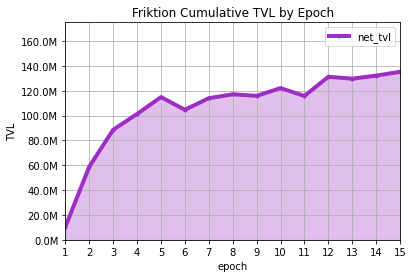

In [198]:
ax = plt.figure().gca()
cumtvl = tvl.groupby("epoch")[["net_tvl"]].sum().cumsum()
cumtvl.plot(grid=True, marker='.', ax=ax, color=CB91_Purple, linewidth=4)
ax.set_xticks(tvl.epoch.unique())

ax.yaxis.set_major_formatter(formatter)

ax.set_ylabel("TVL")
ax.set_title("Friktion Cumulative TVL by Epoch")
ax.set_ylim([0, 1.75e8])
ax.set_xlim([1, 15])
ax.fill_between(cumtvl.net_tvl.index, cumtvl.net_tvl, color=CB91_Purple, alpha=0.3)

In [199]:
tvl["globalId"] = tvl.globalId.fillna(False)

In [200]:
tvl.loc[tvl.globalId.str.contains("circuits").fillna(False)].userAddress.unique()

array(['CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC',
       'WabxR2gcdMgovS6Uo5JD4Cv9me7uExRyaH4QDKrp64b',
       '3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs',
       'DWdU29KENzq87G1cm35XZTZpbBCvyNiTEiSpJgV1CWAf',
       'DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE'], dtype=object)

In [201]:
DAO_WALLETS = [
    'CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC',
   'WabxR2gcdMgovS6Uo5JD4Cv9me7uExRyaH4QDKrp64b',
   '3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs',
   'DWdU29KENzq87G1cm35XZTZpbBCvyNiTEiSpJgV1CWAf',
]

In [202]:
retail = tvl.loc[~tvl.userAddress.isin(DAO_WALLETS)]

In [203]:
retail = retail.loc[retail.net_tvl.abs()>10]

In [204]:
insti = tvl.loc[tvl.userAddress.isin(DAO_WALLETS)]

# ALL

In [205]:
tvl["depositEpoch"] = tvl.groupby("userAddress")["epoch"].transform(lambda x: x.min())

cohorts = tvl.groupby(["depositEpoch", "epoch"])[["net_tvl"]].sum().groupby("depositEpoch").cumsum()

normalize = pd.Series(cohorts.groupby("depositEpoch").net_tvl.first(), name="Initial Deposit")

cohorts_final = cohorts.join(normalize)

cohorts_final["retention"] = cohorts_final["net_tvl"]/cohorts_final["Initial Deposit"]

In [206]:
cohorts_final.unstack(1)["retention"]

epoch,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
depositEpoch,,,,,,,,,,,,,,,,
1,1.0,1.34451,2.081839,2.056670,2.072078,1.931580,1.578234,1.436086,1.275575,1.513266,1.501163,1.476465,1.420677,1.476041,1.316020,1.316020
2,NaN,1.00000,0.991838,1.003673,1.102877,0.911966,0.889367,0.883443,0.881126,0.894476,0.839718,0.932945,0.936184,0.928274,0.911964,0.911964
3,NaN,NaN,1.000000,1.247386,1.231487,1.075733,0.953974,0.870758,0.838896,0.846847,0.818429,0.798573,0.786929,0.778033,0.824947,0.824947
4,NaN,NaN,NaN,1.000000,0.980646,1.105087,3.215662,3.151313,3.136563,3.387732,2.884245,3.007244,2.966620,2.978453,3.275319,3.275319
5,NaN,NaN,NaN,NaN,1.000000,0.968846,0.911496,0.832243,0.757683,0.779121,0.721164,0.700597,0.711546,0.666583,0.644121,0.644121
6,NaN,NaN,NaN,NaN,NaN,1.000000,1.115326,1.083339,1.120334,1.104382,1.099539,0.964548,0.977926,0.895454,0.848388,0.848388
7,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.224188,1.178935,1.059638,0.988371,0.834972,0.761668,0.733933,0.683869,0.683869
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.021278,0.909311,0.942434,0.962383,0.553765,0.580216,0.577827,0.577827
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.127426,1.125561,1.186435,1.671443,0.685517,0.626206,0.626206


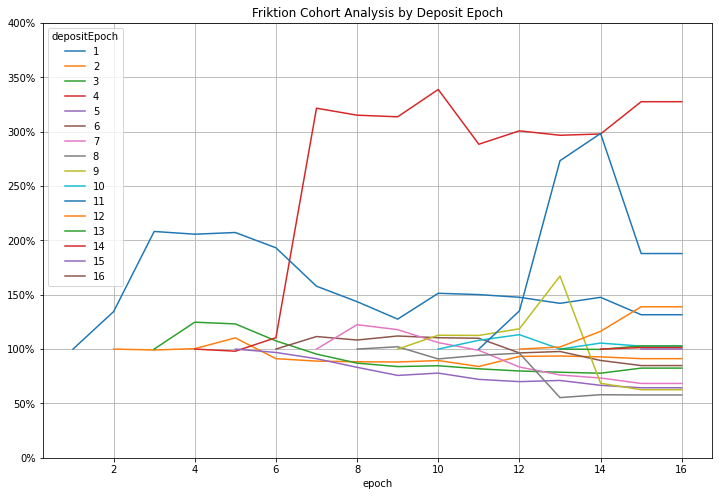

In [208]:
ax = plt.figure().gca()
cohorts_final.unstack(1)["retention"].T.plot(figsize=(12, 8), grid=True, ax=ax)
plt.ylim([0, 4])

plt.title("Friktion Cohort Analysis by Deposit Epoch")
ax.yaxis.set_major_formatter(formatter_percents)

# RETAIL

In [209]:
retail["depositEpoch"] = retail.groupby("userAddress")["epoch"].transform(lambda x: x.min())

cohorts = retail.groupby(["depositEpoch", "epoch"])[["net_tvl"]].sum().groupby("depositEpoch").cumsum()

normalize = pd.Series(cohorts.groupby("depositEpoch").net_tvl.first(), name="Initial Deposit")

cohorts_final = cohorts.join(normalize)

cohorts_final["retention"] = cohorts_final["net_tvl"]/cohorts_final["Initial Deposit"]

In [210]:
cohorts_final

net_tvl  Initial Deposit  retention
depositEpoch epoch                                          
1            1      1.034338e+07     1.034338e+07   1.000000
             2      1.390668e+07     1.034338e+07   1.344500
             3      2.153322e+07     1.034338e+07   2.081836
             4      2.127277e+07     1.034338e+07   2.056655
             5      2.143201e+07     1.034338e+07   2.072051
...                          ...              ...        ...
13           14     6.398960e+05     6.417686e+05   0.997082
             15     6.602659e+05     6.417686e+05   1.028822
14           14     1.816334e+06     1.816334e+06   1.000000
             15     1.847269e+06     1.816334e+06   1.017031
15           15     1.495934e+06     1.495934e+06   1.000000

[120 rows x 3 columns]

In [211]:
cohorts_final.unstack(1)["retention"]

epoch,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
depositEpoch,,,,,,,,,,,,,,,
1,1.0,1.3445,2.081836,2.056655,2.072051,1.931531,1.578106,1.435926,1.275366,1.512966,1.500763,1.475998,1.420206,1.475573,1.315534
2,NaN,1.0000,0.988275,1.000032,1.099222,0.907689,0.885032,0.873813,0.871516,0.884879,0.830114,0.920653,0.923890,0.919001,0.901216
3,NaN,NaN,1.000000,1.245306,1.229143,1.074471,0.953866,0.872182,0.840513,0.848423,0.820222,0.800509,0.788946,0.779753,0.826678
4,NaN,NaN,NaN,1.000000,0.979731,1.106836,3.213639,3.179604,3.164404,3.413551,2.912179,3.052372,3.011770,3.004356,3.311931
5,NaN,NaN,NaN,NaN,1.000000,0.969626,0.912350,0.832933,0.758505,0.779859,0.720841,0.700436,0.711396,0.666422,0.642531
6,NaN,NaN,NaN,NaN,NaN,1.000000,1.114884,1.083153,1.120370,1.104429,1.099662,0.964692,0.977340,0.894900,0.847844
7,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.224241,1.178019,1.059355,0.988258,0.826062,0.752780,0.731261,0.684749
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.020990,0.908141,0.942390,0.962130,0.554211,0.580775,0.578389
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.126506,1.130391,1.191042,1.673624,0.689536,0.630446


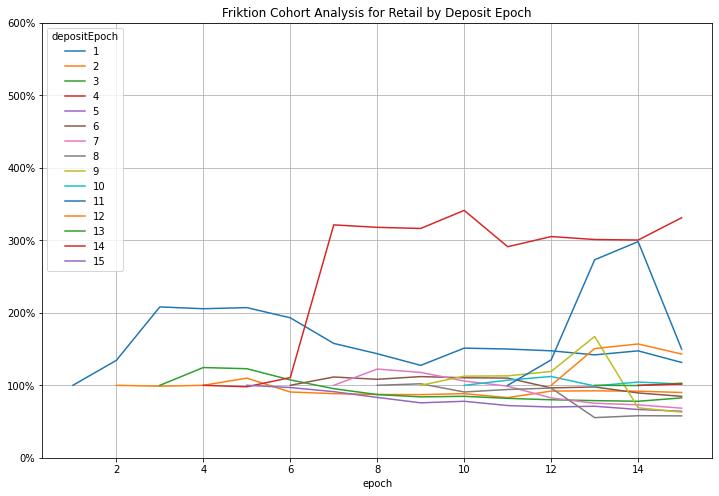

In [212]:
ax = plt.figure().gca()
cohorts_final.unstack(1)["retention"].T.plot(figsize=(12, 8), grid=True, ax=ax)
plt.ylim([0, 6])

plt.title("Friktion Cohort Analysis for Retail by Deposit Epoch")
ax.yaxis.set_major_formatter(formatter_percents)

# insti

In [213]:
insti["depositEpoch"] = insti.groupby("userAddress")["epoch"].transform(lambda x: x.min())

cohorts = insti.groupby(["depositEpoch", "epoch"])[["net_tvl"]].sum().groupby("depositEpoch").cumsum()

normalize = pd.Series(cohorts.groupby("depositEpoch").net_tvl.first(), name="Initial Deposit")

cohorts_final = cohorts.join(normalize)

cohorts_final["retention"] = cohorts_final["net_tvl"]/cohorts_final["Initial Deposit"]

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_3636/2568014994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insti["depositEpoch"] = insti.groupby("userAddress")["epoch"].transform(lambda x: x.min())


In [214]:
cohorts_final.unstack(1)["retention"]

epoch,12,13,14,15
depositEpoch,,,,
12,1.0,NaN,1.145531,1.384675
13,NaN,1.0,0.545455,NaN
14,NaN,NaN,1.000000,NaN


In [215]:
insti

,txSignature,amount,instructionAction,instructionOrder,userAddress,timestamp,currencyName,currencyAddress,senderAddress,senderTokenMint,...,shareTokenMint,depositTokenSymbol,depositTokenCoingeckoId,userAction,symbol,price,amount_usdc,net_tvl,epoch,depositEpoch
491,2Go42nzfCu7VuMvsnT1tme4DhsqxWLNmacon6dS8JneLDb...,1.000000e+00,burn,0-0-2,CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC,2022-03-21T10:32:10Z,NaN,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,AuQHcJZhTd1dnXRrM78RomFiCvW6a9CqxxJ94Fp9h8b,HwcumVNT4QorS8x8vDpTo6ZYvLuQriW3tsxntzEcxxPd,...,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,USDC,usd-coin,Withdraw,USDC,1.0,1.000000e+00,-1.000000e+00,14,13
5497,59QJCZNCKBauHkBcJHxkRYypfyTFyRtdvsAxxtAnofUH2a...,1.000000e+00,burn,0-0-3,CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC,2022-03-20T14:27:57Z,NaN,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,AuQHcJZhTd1dnXRrM78RomFiCvW6a9CqxxJ94Fp9h8b,HwcumVNT4QorS8x8vDpTo6ZYvLuQriW3tsxntzEcxxPd,...,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,USDC,usd-coin,Withdraw,USDC,1.0,1.000000e+00,-1.000000e+00,14,13
5640,5EEaZHLb23h47aUkF41uU3fm5EUtnpFyfc8aJt3fB7pq25...,2.000000e+00,burn,0-0-3,WabxR2gcdMgovS6Uo5JD4Cv9me7uExRyaH4QDKrp64b,2022-03-24T09:08:32Z,NaN,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,7M6TSEkRiXiYmpRCcCDSdJGTGxAPem2HBqjW4gLQ2KoE,3oFdWZeFRQriHCnjc5rmtyqVLqbpRBJugiEPqi5dPuRp,...,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,USDC,usd-coin,Withdraw,USDC,1.0,2.000000e+00,-2.000000e+00,14,14
11988,2GR1JARZMSRP9wEtvVg5D1tbMptBayGuhCt6BuHjevvztx...,2.904146e+06,transfer,0-0,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,2022-03-07T10:10:46Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,8LrqyZvCsyBVFXDU9YbVAj6ukJ9tSKeXTmXNHWfZkGRF,...,Bikt7D3nMQmJSpxX7oczCDKgevrpWk3g4D3VhQZzqAT,USDC,usd-coin,Deposit,USDC,1.0,2.904146e+06,2.904146e+06,12,12
12699,2Pc4jNunQ6EEP9WRCuaBAjDnxhUCPdtjaeG8kASXFA8zbW...,1.000000e+00,transfer,0-0-0,CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC,2022-03-12T10:38:30Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,AuQHcJZhTd1dnXRrM78RomFiCvW6a9CqxxJ94Fp9h8b,FdP14pVP2pdJdRLjE4y7dEXjZoYesxCBpN7VCAXcEvNb,...,BAyzqZuKUQ4k93Yfm3xp85SkAKtr4xghBsqZLBTZT14z,USDC,usd-coin,Deposit,USDC,1.0,1.000000e+00,1.000000e+00,13,13
12826,2QpmcXaPcM92jSR46XEXFVu2cp54J1zqGF8wGBdTdktFjk...,1.000000e+06,transfer,0-0,DWdU29KENzq87G1cm35XZTZpbBCvyNiTEiSpJgV1CWAf,2022-03-09T12:34:40Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,DWdU29KENzq87G1cm35XZTZpbBCvyNiTEiSpJgV1CWAf,7tETtFMNmdg1pZwoy6MxfHpZaUpry4JWwmtSJNLABond,...,J1TX6c1R6WykW2wonvrL6xA2g8vZ2FLDqDDF1mLYrMYK,USDC,usd-coin,Deposit,USDC,1.0,1.000000e+06,1.000000e+06,12,12
12831,2Qs6GVtGyotZQ9bKN1dvrMjasLCZsQx4KQV9wJCN9rwe82...,2.000000e-01,transfer,0-0-1,CkbxaunPif9H3Zq24nyY87pKUe64GRteciPL5qXLUdzC,2022-03-11T10:15:43Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,BZqHAEtN7snbmBD9feFKCSN9fQ9BXJyWQ8B35rnPcoaT,4Wz7SMFnYajxvABd9d1kHRMA8uVthHjS4LwNXAbviyef,...,THjfJ7GUeW6aMU6dzYYFVs5LnKNvmPzgk2wbh3bWagC,USDC,usd-coin,Deposit,USDC,1.0,2.000000e-01,2.000000e-01,13,13
14673,2iXm32JnkCwaVXBdygRUUXBMWtHnBAtfErBGJHBjmUC9N6...,1.000000e+06,transfer,0-0,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,2022-03-07T10:10:10Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,8LrqyZvCsyBVFXDU9YbVAj6ukJ9tSKeXTmXNHWfZkGRF,...,Bikt7D3nMQmJSpxX7oczCDKgevrpWk3g4D3VhQZzqAT,USDC,usd-coin,Deposit,USDC,1.0,1.000000e+06,1.000000e+06,12,12
15682,2tYn2KPx5dCwjR5t3WDFsY2maS6X4xZkdne98bbFC6FPdv...,3.683080e+05,transfer,0-0,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,2022-03-07T11:47:51Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,8LrqyZvCsyBVFXDU9YbVAj6ukJ9tSKeXTmXNHWfZkGRF,...,Bikt7D3nMQmJSpxX7oczCDKgevrpWk3g4D3VhQZzqAT,USDC,usd-coin,Deposit,USDC,1.0,3.683080e+05,3.683080e+05,12,12
16159,2y7w7ZUXjW34ApPSTAt39ezvzh8SzV4NJCphq1v9upDvGq...,2.000000e+00,transfer,0-0-1,WabxR2gcdMgovS6Uo5JD4Cv9me7uExRyaH4QDKrp64

# USER ADDRESS

In [216]:
retail.groupby("userAddress").net_tvl.sum().sort_values()[::-1].head(12).astype('int')

userAddress
5XgStSeDe22PVKojnuHaoboNGiJxgeszhLHsQYAgEBvs    18451472
FrrrZWDn7pCMiGoh35PVZbP8uV2n5nFFJx3uFuyKty2R    18364621
EcH12jxhrbhF6qHqRzWpZ8rZU3TjG3sX6F67zP61oDJG     9852000
7ts1w2Wjg6W9uL8rBfpdQSC7AFDEJeJ2aTE2SEBRHgwJ     3582701
3WGbVryXj7e2u7S1NEghSQbVB6PGZdCXBCoPwRuqUGZ1     2678077
CyAH9f9awBcfuZqHzwwEs4uJBLEG33S743jxnQX1KcZ6     2044194
GFpNdXho1pkJFn1xiH3nXKLY5LqUq5T27b9ZY8dKkNRg     1495828
GNisgcTZZ2WS5PFAEkVUbFso3wNe22cjhmZiEjGcqeHD     1351003
46NAjBDQZMQ3LW6kofZkYug2kLjDeiWW6ewUFAAMsB1S     1269807
BQfguZpr4hje4irm9xkcp7yrrKhWgCMCfEB51r3Ecrhg     1204977
3GYPiqCrAXkhH8xcRi8jJTLhdsXkyJS52qtHqbWGNeoR     1058958
C3bc3VVWoazK29ziUrZNUPraSKxZkfT88wVaDHdc7bnt     1010430
Name: net_tvl, dtype: int64

In [217]:
powerusers = retail.groupby("userAddress").net_tvl.sum().sort_values()[::-1].head(12).astype('int').index

In [218]:
retail.groupby("userAddress").net_tvl.sum().sort_values()[::-1][12:].sum()

56628115.753269374

In [219]:
retail.loc[retail.userAddress.isin(powerusers)].groupby("globalId").net_tvl.sum().astype('int').sort_values()[::-1]

globalId
mainnet_income_call_srm         14271745
mainnet_income_call_btc         11464660
mainnet_income_call_sol         10990932
mainnet_income_call_marinade     6467401
mainnet_income_call_ftt          5343642
mainnet_income_put_sol           4984524
mainnet_income_call_luna         2293022
mainnet_income_call_socean       2130950
mainnet_income_put_sol_high      1540712
mainnet_income_put_btc           1205095
mainnet_income_call_eth           862861
mainnet_income_call_mngo          251882
mainnet_income_put_mngo           200000
mainnet_income_put_luna           199979
mainnet_income_call_sbr           106663
mainnet_income_put_eth             50000
Name: net_tvl, dtype: int64

<AxesSubplot:>

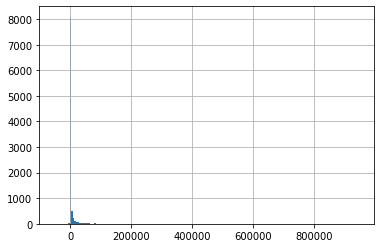

In [220]:
retail.loc[~retail.userAddress.isin(powerusers)].groupby("userAddress").net_tvl.sum().hist(bins=200)

In [221]:
hist=retail.groupby("userAddress").net_tvl.sum()

qq = pd.DataFrame(hist.quantile(np.linspace(.1, 1, 99, 0))).reset_index()
qq.columns=["percentile", "tvl"]
qq

,percentile,tvl
0,0.100000,1.661120
1,0.109091,2.477934
2,0.118182,3.121382
3,0.127273,4.067217
4,0.136364,4.938485
...,...,...
94,0.954545,21241.301783
95,0.963636,28692.871617
96,0.972727,42153.351955
97,0.981818,67868.683848


Text(0.5, 1.0, 'Friktion TVL per Wallet \n Retail Cumulative Percentage Distribution')

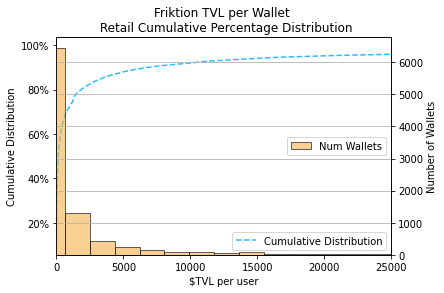

In [222]:
ax = plt.figure().gca()
ax2=ax.twinx()
ax.plot(qq.tvl, qq.percentile, color=CB91_Blue, linestyle='dashed', label="Cumulative Distribution")
plt.grid(True)
ax.set_xlim([0, 25000])
hist.hist(bins=10000, ax=ax2, edgecolor='black', color=CB91_Amber, alpha=0.6, label="Num Wallets")
ax.yaxis.set_major_formatter(formatter_percents)

ax.set_xlabel("$TVL per user")
ax.set_ylabel("Cumulative Distribution")
ax2.set_ylabel("Number of Wallets")

ax.legend(loc='lower right')
ax2.legend(loc='center right')
ax.set_title("Friktion TVL per Wallet \n Retail Cumulative Percentage Distribution")

In [223]:
hist=insti.groupby("userAddress").net_tvl.sum()

qq = pd.DataFrame(hist.quantile(np.linspace(.1, 1, 99, 0))).reset_index()
qq.columns=["percentile", "tvl"]
qq

,percentile,tvl
0,0.100000,3.000008e+05
1,0.109091,3.272735e+05
2,0.118182,3.545462e+05
3,0.127273,3.818189e+05
4,0.136364,4.090916e+05
...,...,...
94,0.954545,1.242719e+07
95,0.963636,1.278804e+07
96,0.972727,1.314890e+07
97,0.981818,1.350975e+07


Text(0.5, 1.0, 'Friktion TVL per Wallet\n Circuits Cumulative Percentage Distribution')

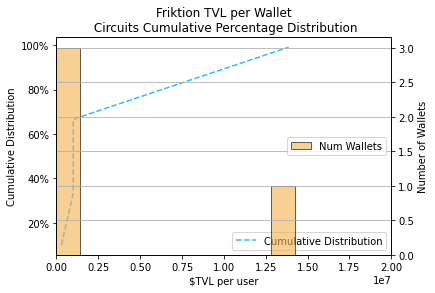

In [224]:
ax = plt.figure().gca()
ax2=ax.twinx()
ax.plot(qq.tvl, qq.percentile, color=CB91_Blue, linestyle='dashed', label="Cumulative Distribution")
plt.grid(True)
ax.set_xlim([0, 2e7])
hist.hist(bins=10, ax=ax2, edgecolor='black', color=CB91_Amber, alpha=0.6, label="Num Wallets")
ax.yaxis.set_major_formatter(formatter_percents)

ax.set_xlabel("$TVL per user")
ax.set_ylabel("Cumulative Distribution")
ax2.set_ylabel("Number of Wallets")

ax.legend(loc='lower right')
ax2.legend(loc='center right')
ax.set_title("Friktion TVL per Wallet\n Circuits Cumulative Percentage Distribution")

# COHORT analysis # users with non-zero balances

In [357]:
retail = tvl#.loc[~tvl.userAddress.isin(DAO_WALLETS)]

# retail = retail.loc[retail.net_tvl.abs()>10]

user_cohort = retail.copy(deep=True)

user_cohort["depositEpoch"] = retail.groupby("userAddress")["epoch"].transform(lambda x: x.min())

tvls = user_cohort.groupby(["depositEpoch", "epoch"]).net_tvl.sum().unstack(0).cumsum().fillna(0)

In [358]:
stackers = [tvls[col].values for col in tvls.columns]

In [359]:
import matplotlib
colors = list(matplotlib.colors.cnames.values())[16:32]


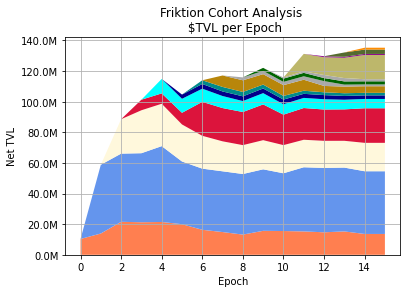

In [360]:
ax = plt.figure().gca()

ax.stackplot(np.arange(16), stackers, colors=colors)
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Net TVL")

plt.title("Friktion Cohort Analysis \n $TVL per Epoch")

ax.yaxis.set_major_formatter(millions)

depositEpoch      1       2       3      4       5      6      7      8   \
epoch                                                                      
1             1012.0     NaN     NaN    NaN     NaN    NaN    NaN    NaN   
2              989.0  1209.0     NaN    NaN     NaN    NaN    NaN    NaN   
3              964.0  1163.0  1138.0    NaN     NaN    NaN    NaN    NaN   
4              949.0  1123.0  1084.0  911.0     NaN    NaN    NaN    NaN   
5              942.0  1108.0  1055.0  867.0  1342.0    NaN    NaN    NaN   
6              934.0  1095.0  1035.0  855.0  1284.0  679.0    NaN    NaN   
7              927.0  1074.0  1014.0  844.0  1235.0  656.0  711.0    NaN   
8              926.0  1062.0  1004.0  834.0  1195.0  639.0  676.0  501.0   
9              920.0  1056.0   993.0  831.0  1163.0  626.0  658.0  486.0   
10             917.0  1051.0   990.0  829.0  1145.0  612.0  652.0  470.0   
11             913.0  1033.0   987.0  822.0  1135.0  600.0  641.0  457.0   
12          

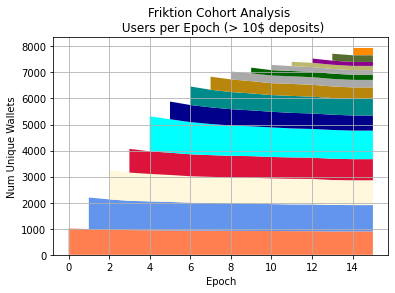

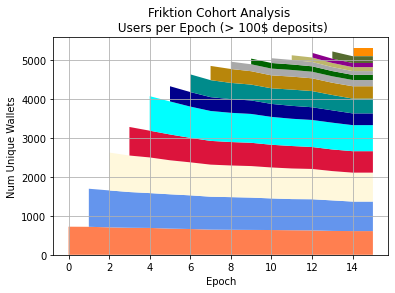

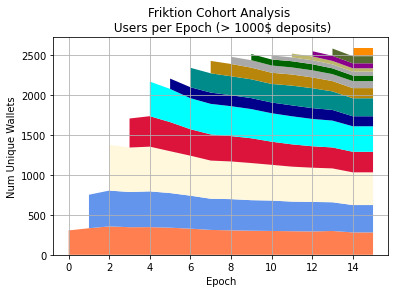

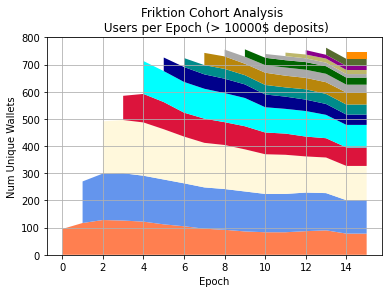

In [383]:
min_deposits = [10, 100, 1000, 10000]
ogs = []

for min_deposit in min_deposits:
    user_cohorts = user_cohort.groupby(["userAddress", "depositEpoch", "epoch"])[["net_tvl"]].sum()

    playas = user_cohorts.unstack(2).fillna(0).cumsum(axis=1).stack("epoch")

    playas=playas.loc[playas.net_tvl>min_deposit]

    user_cohorts = playas.reset_index().groupby(["depositEpoch", "epoch"]).userAddress.count().unstack(1).T

    print(user_cohorts)
    ogs.append(user_cohorts)

    stackers = [user_cohorts[col].values for col in user_cohorts.columns]

    ax = plt.figure().gca()

    ax.stackplot(np.arange(16), stackers, colors=colors)
    plt.grid(True)
    plt.xlabel("Epoch")
    plt.ylabel("Num Unique Wallets")

    plt.title(f"Friktion Cohort Analysis \n Users per Epoch (> {min_deposit}$ deposits)")

    # ax.yaxis.set_major_formatter(millions)

In [389]:
ogs[0].fillna(0).astype('int')

depositEpoch,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
epoch,,,,,,,,,,,,,,,
1,1012,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,989,1209,0,0,0,0,0,0,0,0,0,0,0,0,0
3,964,1163,1138,0,0,0,0,0,0,0,0,0,0,0,0
4,949,1123,1084,911,0,0,0,0,0,0,0,0,0,0,0
5,942,1108,1055,867,1342,0,0,0,0,0,0,0,0,0,0
6,934,1095,1035,855,1284,679,0,0,0,0,0,0,0,0,0
7,927,1074,1014,844,1235,656,711,0,0,0,0,0,0,0,0
8,926,1062,1004,834,1195,639,676,501,0,0,0,0,0,0,0
9,920,1056,993,831,1163,626,658,486,303,0,0,0,0,0,0
